In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from scipy.signal import fftconvolve
from astropy.io import fits
import numpy as np
import math
from pathlib import Path
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from vacuum.model import create_model
from vacuum.io import load_data, preprocess, deprocess, fits_open

In [11]:
INPUT_DIR = "/scratch/datasets/kat7_2000/raw"

SEPARABLE_CONV = False   # use separable convolutions in the generator
NGF = 64                 # number of generator filters in first conv layer
NDF = 64                 # number of discriminator filters in first conv laye
BATCH_SIZE = 1           # number of images in batch
CROP_SIZE = 256
EPS = 1e-12
FLIP = False              # flip images horizontally during training
SCALE_SIZE = 256         # scale images to this size before cropping to 256x256
MAX_EPOCHS = 1           # number of training epochs
LR = 0.0002              # initial learning rate for adam
BETA1 = 0.5              # momentum term of adam
L1_WEIGHT = 100.0        # weight on L1 term for generator gradient
GAN_WEIGHT = 1.0         # weight on GAN term for generator gradient
INPUT_MULTIPLY = 1.0     # Use this to scale in the max input fluxes to about 5 Jy 
DATA_START = 1840
DATA_END = 1899

In [12]:
batch, count = load_data(INPUT_DIR, CROP_SIZE, FLIP, SCALE_SIZE, MAX_EPOCHS,
                         BATCH_SIZE, INPUT_MULTIPLY, start=DATA_START, end=DATA_END,
                         types=("wsclean-psf", "wsclean-dirty", "skymodel"))
steps_per_epoch = int(math.ceil(count / BATCH_SIZE))
iter = batch.make_one_shot_iterator()
index, psf, dirty, skymodel = iter.get_next()
print("examples count = %d" % count)

examples count = 59


In [13]:
deprocessed_dirty = deprocess(dirty, INPUT_MULTIPLY)
deprocessed_skymodel = deprocess(skymodel, INPUT_MULTIPLY)
#deprocessed_ouput = deprocess(model.outputs, INPUT_MULTIPLY)

In [14]:
def render(a, imgdata, title):
    i = a.pcolor(imgdata, cmap='cubehelix')
    f.colorbar(i, ax=a)
    a.set_title(title)

In [15]:
def shift(i, x=0, y=0):
    return tf.image.pad_to_bounding_box(
        i,
        max(0, y),
        max(0, x),
        i.shape.as_list()[1] + abs(y),
        i.shape.as_list()[2] + abs(x))

In [16]:
shifted = shift(psf, y=-1, x=-1)
filter_ = tf.expand_dims(tf.expand_dims(tf.squeeze(shifted), 2), 3)
convolved = tf.nn.conv2d(deprocessed_skymodel, filter_, [1, 1, 1, 1], "SAME")
residual = deprocessed_dirty - convolved

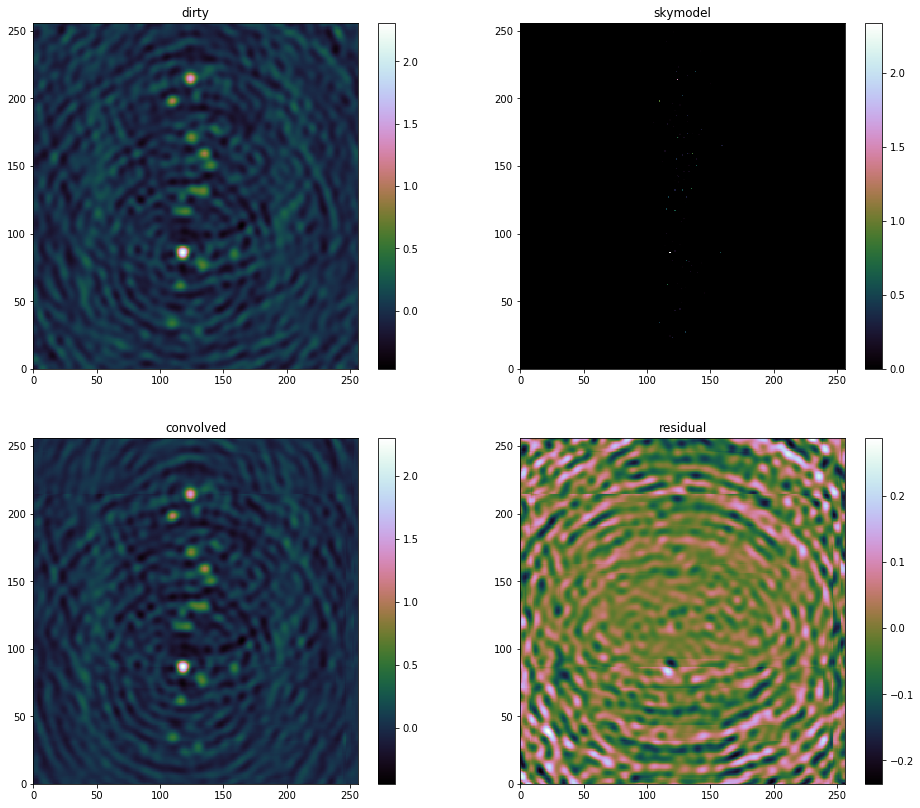

In [17]:
f, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(16,14))
render(a1, deprocessed_dirty.numpy().squeeze(), 'dirty')
render(a2, deprocessed_skymodel.numpy().squeeze(), 'skymodel')
render(a3, convolved.numpy().squeeze(), 'convolved')
render(a4, residual.numpy().squeeze(), 'residual')